In [1]:
#https://zindi.africa/competitions/financial-inclusion-in-africa/leaderboard?page=34

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from imblearn.under_sampling import NearMiss, TomekLinks

import imblearn


import warnings
warnings.filterwarnings("ignore")

RSEED=42

In [3]:
pd.set_option('display.max_colwidth', None)

In [4]:
test_data = pd.read_csv("data/financial-inclusion-in-africa20250311-22142-nbnoiv/Test.csv")
train_data = pd.read_csv("data/financial-inclusion-in-africa20250311-22142-nbnoiv/Train.csv")

In [5]:
variable_definitions = pd.read_csv("data/financial-inclusion-in-africa20250311-22142-nbnoiv/VariableDefinitions.csv")

In [6]:
variable_definitions

,Variable Definitions,Unnamed: 1
0,country,Country interviewee is in.
1,year,Year survey was done in.
2,uniqueid,Unique identifier for each interviewee
3,location_type,"Type of location: Rural, Urban"
4,cellphone_access,"If interviewee has access to a cellphone: Yes, No"
5,household_size,Number of people living in one house
6,age_of_respondent,The age of the interviewee
7,gender_of_respondent,"Gender of interviewee: Male, Female"
8,relationship_with_head,"The interviewee’s relationship with the head of the house:Head of Household, Spouse, Child, Parent, Other relative, Other non-relatives, Dont know"
9,marital_status,"The martial status of the interviewee: Married/Living together, Divorced/Seperated, Widowed, Single/Never Married, Don’t know"


In [7]:
variable_definitions.shape

(12, 2)

In [8]:
train_data.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [9]:
train_data.shape

(23524, 13)

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


In [11]:
train_data.bank_account.value_counts()

bank_account
No     20212
Yes     3312
Name: count, dtype: int64

In [12]:
train_data.describe()

,year,household_size,age_of_respondent
count,23524.000000,23524.000000,23524.000000
mean,2016.975939,3.797483,38.805220
std,0.847371,2.227613,16.520569
min,2016.000000,1.000000,16.000000
25%,2016.000000,2.000000,26.000000
50%,2017.000000,3.000000,35.000000
75%,2018.000000,5.000000,49.000000
max,2018.000000,21.000000,100.000000


In [13]:
train_data = train_data.query("marital_status != 'Dont know'")   # otherwise we will have problems later with one-hot-encoding and using X_test and X_train

In [14]:
y = train_data.bank_account
X = train_data.drop("bank_account", axis=1)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=RSEED)

## Baseline model

In [16]:
def baseline_model(row):
    
    gender = row['gender_of_respondent']
    job = row['job_type']
    
    if job in ['Government Dependent', 'Formally employed Government', 'Formally employed Private'] and gender == "Male":
        return 'Yes'
    else:
        return 'No'

### Baseline model on test data

In [17]:
# Apply baseline model to each row in the DataFrame
y_pred_baseline = X_test.apply(baseline_model, axis=1)

In [136]:
print("Performance baseline model on test data:")
print("")
print(classification_report(y_test, y_pred_baseline))

Performance baseline model on test data:

              precision    recall  f1-score   support

          No       0.88      0.98      0.93      5052
         Yes       0.66      0.18      0.28       827

    accuracy                           0.87      5879
   macro avg       0.77      0.58      0.60      5879
weighted avg       0.85      0.87      0.84      5879



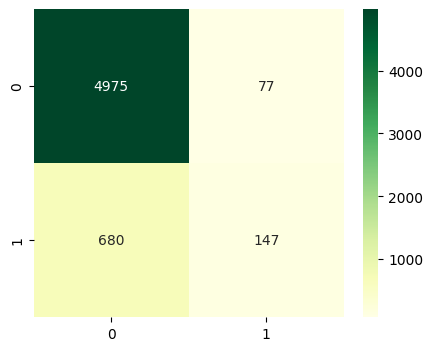

In [137]:
cm = metrics.confusion_matrix(y_test, y_pred_baseline)#, normalize='all')
fig, ax = plt.subplots(figsize=(5, 4))  
sns.heatmap(cm, annot=True, cmap='YlGn', ax=ax, fmt='d')
plt.show()

### Baseline model on train data

In [138]:
# Apply baseline model to each row in the DataFrame
y_pred_train_baseline = X_train.apply(baseline_model, axis=1)

In [139]:
print("Performance baseline model on test data:")
print("")
print(classification_report(y_train, y_pred_train_baseline))

Performance baseline model on test data:

              precision    recall  f1-score   support

          No       0.88      0.98      0.93     15154
         Yes       0.61      0.16      0.25      2483

    accuracy                           0.87     17637
   macro avg       0.74      0.57      0.59     17637
weighted avg       0.84      0.87      0.83     17637



In [228]:
X_train.shape

(17637, 12)

In [230]:
X_train.columns

Index(['country', 'year', 'uniqueid', 'location_type', 'cellphone_access',
       'household_size', 'age_of_respondent', 'gender_of_respondent',
       'relationship_with_head', 'marital_status', 'education_level',
       'job_type'],
      dtype='object')

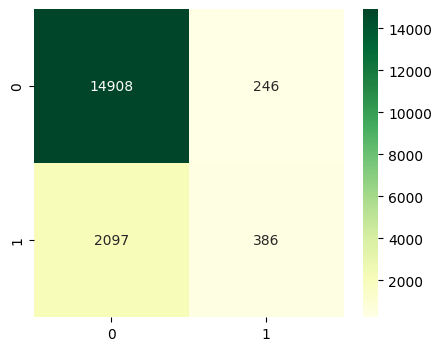

In [140]:
cm = metrics.confusion_matrix(y_train, y_pred_train_baseline)#, normalize='all')
fig, ax = plt.subplots(figsize=(5, 4))  
sns.heatmap(cm, annot=True, cmap='YlGn', ax=ax, fmt='d')
plt.show()

## Class imbalance

In [141]:
list(train_data.bank_account.value_counts())

[20206, 3310]

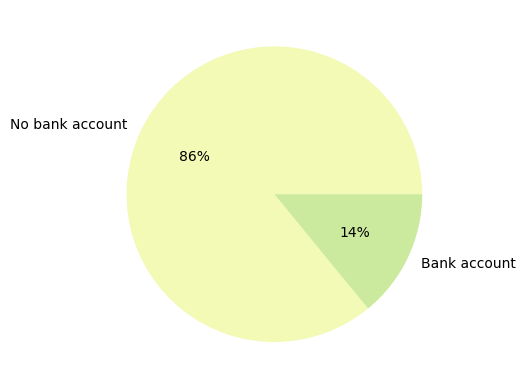

In [142]:
colors = sns.color_palette('YlGn')
plt.pie(list(train_data.bank_account.value_counts()), colors=colors, labels=["No bank account", "Bank account"], autopct='%.0f%%')
plt.show()

## Feature Engineering: one-hot-encoding, feature selection

In [143]:
def convert_truth_labels(y_train, y_test):
    y_train = y_train.map({"Yes": 1, "No": 0})
    y_test = y_test.map({"Yes": 1, "No": 0})
    return y_train, y_test

In [144]:
y_train, y_test = convert_truth_labels(y_train, y_test)

### Feature selection

In [145]:
def data_filtering_for_features(X_train_data, X_test_data, cat_features_list, num_features_list):
    
    features = cat_features_list + num_features_list
    X_train_data = X_train_data[features]
    X_test_data = X_test_data[features]
    return X_train_data, X_test_data

In [146]:
cat_features = ['country', 'location_type', 'cellphone_access', 
                'gender_of_respondent', 'relationship_with_head', 
                'marital_status', 'education_level', 'job_type']

num_features = ['household_size', 'age_of_respondent']

In [147]:
X_train_selected_feats, X_test_selected_feats = data_filtering_for_features(X_train, X_test, cat_features, num_features)

In [148]:
X_train_selected_feats.shape, X_test_selected_feats.shape

((17637, 10), (5879, 10))

### One-hot-encoding

In [149]:
X_train_selected_feats_1hotenc = pd.get_dummies(X_train_selected_feats, drop_first=True)
X_test_selected_feats_1hotenc = pd.get_dummies(X_test_selected_feats, drop_first=True)

In [150]:
X_train_selected_feats_1hotenc.shape, X_test_selected_feats_1hotenc.shape

((17637, 30), (5879, 30))

## Dealing with imbalanced data: balanced_weights

## MaxVoting Ensemble Method 

In [151]:
model1 = LogisticRegression(random_state = RSEED, class_weight="balanced")
model2 = XGBClassifier(random_state = RSEED, class_weight="balanced")
model3 = RandomForestClassifier(random_state = RSEED, n_estimators = 100, class_weight="balanced", max_depth=10, min_samples_leaf=10)

model = VotingClassifier(estimators = [('lr', model1), ('xgb', model2), ('rf', model3)], voting = 'soft') 
model.fit(X_train_selected_feats_1hotenc, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(class_weight='balanced',
                                                 random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            class_weight='balanced',
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=Non...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=10,
                                                     min_samples_leaf=10,
                                                     random_state=42))],
                 voting='soft')

In [152]:
train_predictions = model.predict(X_train_selected_feats_1hotenc)
test_predictions = model.predict(X_test_selected_feats_1hotenc)

In [153]:
print(classification_report(y_train, train_predictions))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93     15154
           1       0.57      0.66      0.61      2483

    accuracy                           0.88     17637
   macro avg       0.75      0.79      0.77     17637
weighted avg       0.89      0.88      0.88     17637



In [154]:
print(classification_report(y_test, test_predictions))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92      5052
           1       0.53      0.62      0.57       827

    accuracy                           0.87      5879
   macro avg       0.73      0.76      0.75      5879
weighted avg       0.88      0.87      0.87      5879



## Roc curve

In [175]:
test_predictions_probs = model.predict_proba(X_test_selected_feats_1hotenc)

In [189]:
test_predictions_probs[:,1]

array([0.0472497 , 0.03802928, 0.24144899, ..., 0.6817701 , 0.27484003,
       0.14493255])

In [184]:
test_predictions

array([0, 0, 0, ..., 1, 0, 0])

In [190]:
fpr, tpr, thresholds = roc_curve(y_test, test_predictions_probs[:,1])

In [193]:
thresholds

array([1.98693306, 0.98693306, 0.97856272, ..., 0.01302105, 0.01300402,
       0.0098423 ])

Text(0, 0.5, 'True Positive Rate')

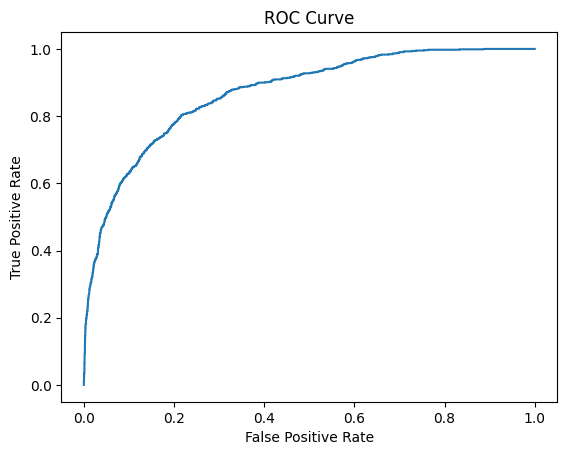

In [199]:
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [195]:
roc_auc_score(y_test, test_predictions_probs[:,1])

0.8703471801367352

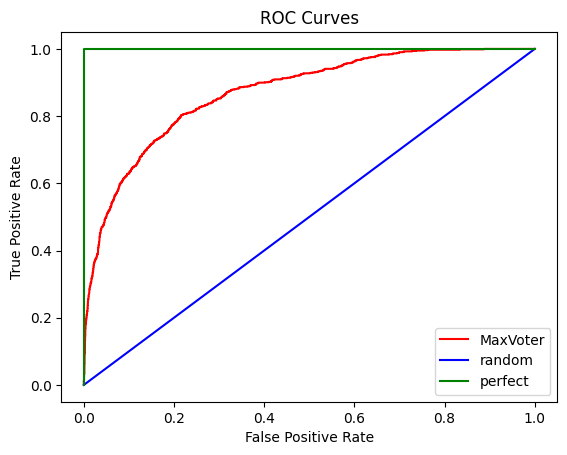

In [212]:
import matplotlib.pyplot as plt

plt.plot(fpr,tpr,'r-', label= 'MaxVoter')
plt.plot([0,1],[0,1],'b-',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
plt.title("ROC Curves")
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

## ROC curve for baseline model

In [169]:
y_pred_baseline_conv = y_pred_baseline.map({"Yes": 1, "No": 0})

In [171]:
fpr_baseline, tpr_baseline, thresholds_baseline = roc_curve(y_pred_baseline_conv, test_predictions)

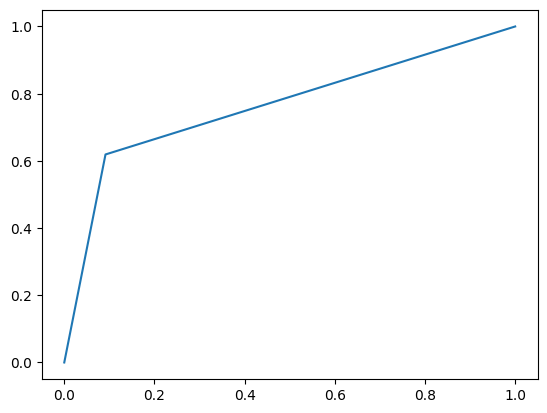

In [172]:
plt.plot(fpr, tpr)

In [173]:
roc_auc_score(y_pred_baseline_conv, test_predictions)

0.8455057155488189

In [206]:
list(thresholds_baseline)

[2, 1, 0]

In [205]:
list(fpr_baseline)

[0.0, 0.13934571175950486, 1.0]

In [208]:
list(tpr_baseline)

[0.0, 0.8303571428571429, 1.0]

In [214]:
tips = sns.load_dataset("tips")

In [216]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [221]:
#scores = {"precision": [0.66, 0.53], "recall": [0.18, 0.62], "F1-score": [0.28, 0.57], 'model': ["Baseline", "MaxVoter"]}
scores = {"metric": ["precision", "recall", "f-score", "precision", "recall", "f-score"], 
          "score": [0.66, 0.18, 0.28, 0.53, 0.62, 0.57], 
          "model": ["Baseline", "Baseline", "Baseline", "MaxVoter", "MaxVoter", "MaxVoter"]}
df = pd.DataFrame.from_dict(scores)

In [222]:
df

,metric,score,model
0,precision,0.66,Baseline
1,recall,0.18,Baseline
2,f-score,0.28,Baseline
3,precision,0.53,MaxVoter
4,recall,0.62,MaxVoter
5,f-score,0.57,MaxVoter


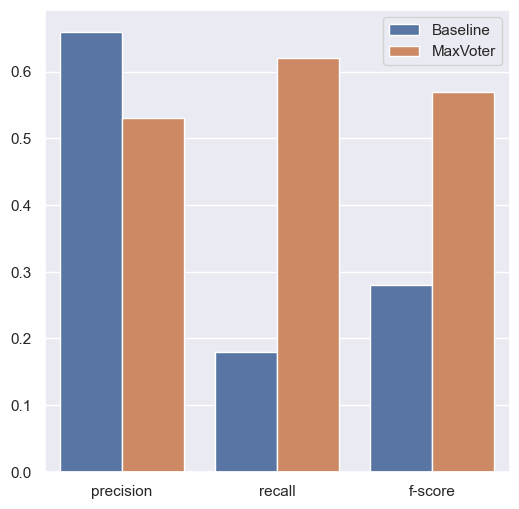

In [225]:
# set plot style: grey grid in the background:
sns.set_theme(style="darkgrid")

# Set the figure size
plt.figure(figsize=(6, 6))

# grouped barplot
sns.barplot(x="metric", y="score", hue="model", data=scores, ci=None);

In [231]:
accuracy_score(y_test, test_predictions)

0.8678346657594829

In [232]:
1-accuracy_score(y_test, test_predictions)

0.13216533424051713